## Volume based trading 

looking at medium frequency trading in high volatile hours

<Figure size 1200x800 with 0 Axes>

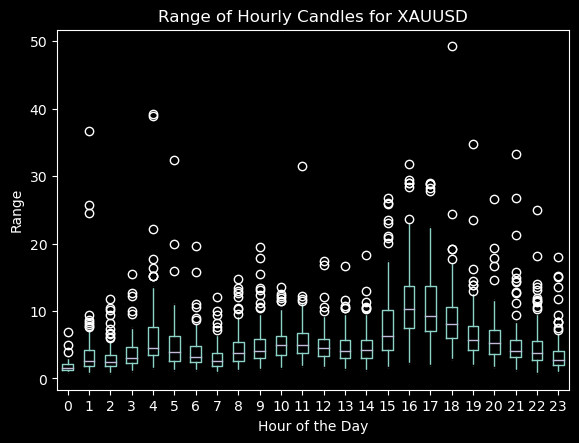

In [19]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import numpy as np
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
plt.style.use('dark_background')

# Initialize MetaTrader 5
mt5.initialize()

# Settings
symbol = 'XAUUSD'
timeframe = mt5.TIMEFRAME_H1
start_date = datetime(2024, 1, 1)
end_time = datetime.now()

# Function to get data from MetaTrader 5
def get_data(symbol, timeframe, start_date, end_time):
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_time)
    if rates is None:
        raise ValueError(f"Failed to get rates for {symbol}")
    df = pd.DataFrame(rates)
    df = df[['time', 'open', 'high', 'low', 'close', 'tick_volume']]
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def calculate_range(symbol, timeframe, start_date, end_time):
    data = get_data(symbol, timeframe, start_date, end_time)
    data['range'] = data['high'] - data['low']
    return data

data = calculate_range(symbol, timeframe, start_date, end_time)

# Extract the hour from the index and group by hour
data['hour'] = data.index.hour

# Create a boxplot
plt.figure(figsize=(12, 8))
data.boxplot(column='range', by='hour', grid=False)
plt.title(f'Range of Hourly Candles for {symbol}')
plt.suptitle('')  # Suppress the automatic 'Boxplot grouped by hour' title
plt.xlabel('Hour of the Day')
plt.ylabel('Range')
plt.show()


In [20]:
xauusd = get_data(symbol, mt5.TIMEFRAME_M5, datetime(2024, 5, 22), datetime(2024, 6, 14))
# Calculate the moving average of the tick volume
xauusd['tick_volume_ma'] = xauusd['tick_volume'].rolling(window=360).mean()
xauusd

,open,high,low,close,tick_volume,tick_volume_ma
time,,,,,,
2024-05-21 23:00:00,2423.29,2423.38,2422.50,2422.77,208,NaN
2024-05-21 23:05:00,2422.74,2422.83,2422.42,2422.57,129,NaN
2024-05-21 23:10:00,2422.57,2423.31,2422.43,2422.80,168,NaN
2024-05-21 23:15:00,2422.68,2422.87,2422.38,2422.39,91,NaN
2024-05-21 23:20:00,2422.47,2422.57,2421.12,2421.67,119,NaN
...,...,...,...,...,...,...
2024-06-13 22:40:00,2304.45,2304.94,2304.09,2304.59,272,833.186111
2024-06-13 22:45:00,2304.60,2304.76,2304.24,2304.52,251,823.688889
2024-06-13 22:50:00,2304.56,2304.60,2303.20,2303.34,304,813.891667


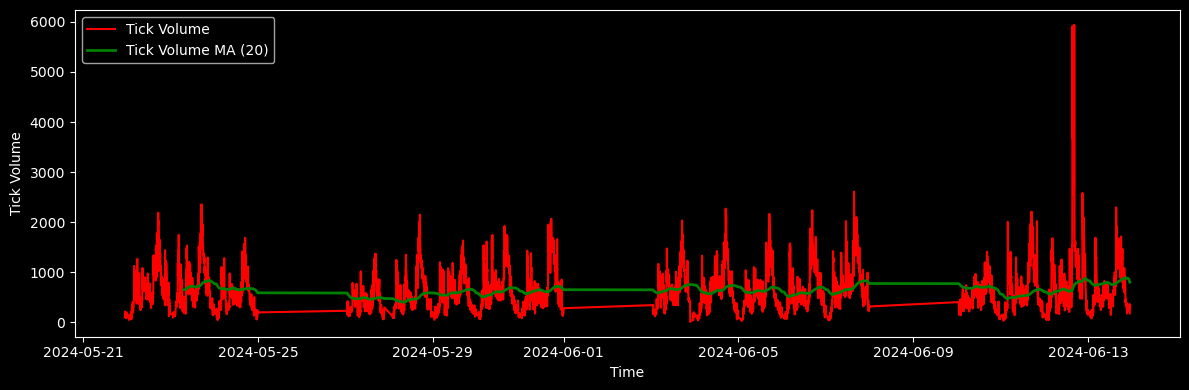

In [21]:
# Plotting
plt.figure(figsize=(12, 4))  # Set figure size here

# Plot the tick volume
plt.plot(xauusd.index, xauusd['tick_volume'], color='red', label='Tick Volume')

# Plot the moving average of the tick volume
plt.plot(xauusd.index, xauusd['tick_volume_ma'], label='Tick Volume MA (20)', color='green', linewidth=2)

plt.ylabel('Tick Volume')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Identify signals
xauusd['signal'] = 0
# xauusd['tick_volume'] > xauusd['tick_volume_ma']
xauusd['signal'] = xauusd['tick_volume'] > xauusd['tick_volume_ma']

# xauusd['tick_volume'] > 1000
#xauusd['signal'] = xauusd['tick_volume'] > 100

# Define entry and exit points
xauusd['positions'] = xauusd['signal'].diff()
# Determine trade direction
xauusd['direction'] = np.where(xauusd['close'].shift(1) > xauusd['close'].shift(2), 1, -1)
# Set trade signal only between 14:00 and 17:00
xauusd['trade'] = 0  # Initialize trade column
mask = (xauusd.index.hour >= 14) & (xauusd.index.hour <= 21)
xauusd.loc[mask, 'trade'] = xauusd['signal'] * xauusd['direction']

xauusd

,open,high,low,close,tick_volume,tick_volume_ma,signal,positions,direction,trade
time,,,,,,,,,,
2024-05-21 23:00:00,2423.29,2423.38,2422.50,2422.77,208,NaN,False,NaN,-1,0
2024-05-21 23:05:00,2422.74,2422.83,2422.42,2422.57,129,NaN,False,False,-1,0
2024-05-21 23:10:00,2422.57,2423.31,2422.43,2422.80,168,NaN,False,False,-1,0
2024-05-21 23:15:00,2422.68,2422.87,2422.38,2422.39,91,NaN,False,False,1,0
2024-05-21 23:20:00,2422.47,2422.57,2421.12,2421.67,119,NaN,False,False,-1,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-13 22:40:00,2304.45,2304.94,2304.09,2304.59,272,833.186111,False,False,-1,0
2024-06-13 22:45:00,2304.60,2304.76,2304.24,2304.52,251,823.688889,False,False,1,0
2024-06-13 22:50:00,2304.56,2304.60,2303.20,2303.34,304,813.891667,False,False,-1,0


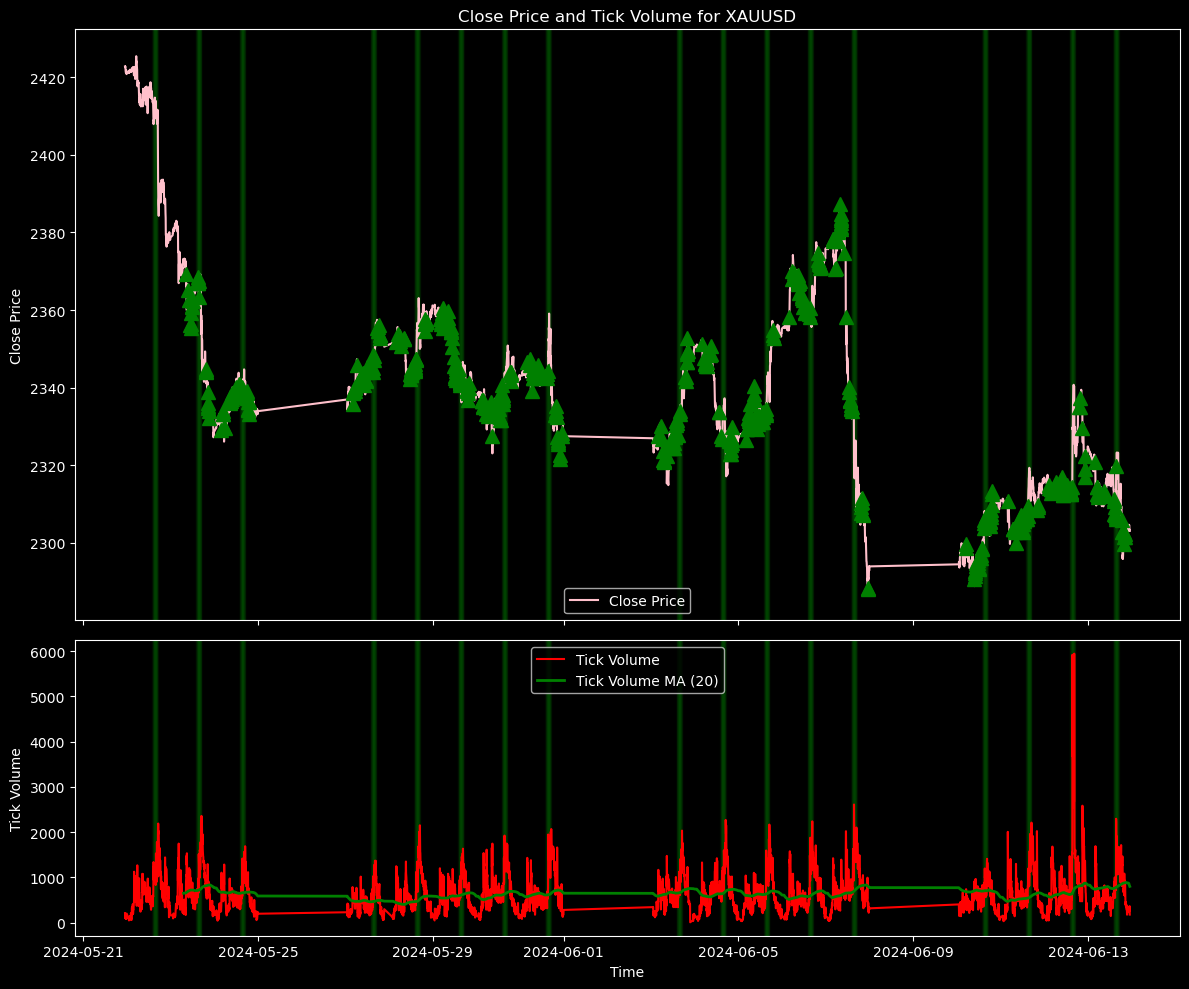

In [23]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the close prices
ax1.plot(xauusd.index, xauusd['close'], label='Close Price', color='pink')
ax1.set_ylabel('Close Price')
ax1.set_title('Close Price and Tick Volume for XAUUSD')
ax1.legend()

# Highlight entry points
ax1.plot(xauusd[xauusd['positions'] == 1].index,
         xauusd['close'][xauusd['positions'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

ax1.plot(xauusd[xauusd['positions'] == -1].index,
         xauusd['close'][xauusd['positions'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')

# Plot the tick volume
ax2.plot(xauusd.index, xauusd['tick_volume'], color='red', label='Tick Volume')
ax2.plot(xauusd.index, xauusd['tick_volume_ma'], label='Tick Volume MA (20)', color='green', linewidth=2)

# Highlight the periods between 14:00 and 16:00 with a dark green background
start_time = xauusd.between_time('14:00', '16:00').index
for s in start_time:
    ax1.axvspan(s, s + pd.Timedelta(hours=1), color='darkgreen', alpha=0.05)
    ax2.axvspan(s, s + pd.Timedelta(hours=1), color='darkgreen', alpha=0.05)

ax2.set_ylabel('Tick Volume')
ax2.set_xlabel('Time')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
xauusd.columns = xauusd.columns.str.title()
xauusd = xauusd.dropna()

In [25]:
xauusd

,Open,High,Low,Close,Tick_Volume,Tick_Volume_Ma,Signal,Positions,Direction,Trade
time,,,,,,,,,,
2024-05-23 07:10:00,2372.80,2373.20,2372.25,2372.88,243,646.555556,False,False,-1,0
2024-05-23 07:15:00,2372.87,2373.60,2372.81,2373.09,227,646.608333,False,False,1,0
2024-05-23 07:20:00,2373.10,2373.21,2371.87,2372.55,185,646.763889,False,False,1,0
2024-05-23 07:25:00,2372.49,2372.99,2371.75,2371.87,257,647.011111,False,False,-1,0
2024-05-23 07:30:00,2371.84,2372.86,2371.50,2372.84,328,647.669444,False,False,-1,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-13 22:40:00,2304.45,2304.94,2304.09,2304.59,272,833.186111,False,False,-1,0
2024-06-13 22:45:00,2304.60,2304.76,2304.24,2304.52,251,823.688889,False,False,1,0
2024-06-13 22:50:00,2304.56,2304.60,2303.20,2303.34,304,813.891667,False,False,-1,0


## Backtesting the strategy 

In [26]:
def SIGNAL(data):
    return data['Trade']

# Create the strategy class
class VolumeMA(Strategy):
    initsize = 2.0
    mysize = initsize
    in_position = False
    
    def init(self):
        # Initialize the indicator
        self.signal1 = self.I(SIGNAL, self.data.df, plot=True)
        
    def next(self):
        pip_value = 1
        current_hour = self.data.index[-1].hour
        
        # Trading Logic
        if 14 <= current_hour <= 17:  # Only take trades between 14:00 and 16:00
            if not self.in_position:
                if self.signal1[-1] == 1:
                    sl1 = self.data.Close[-1] - (2.5 * pip_value)
                    tp1 = self.data.Close[-1] + (7.5 * pip_value)
                    self.buy(sl=sl1, tp=tp1, size=self.mysize)
                    self.in_position = True
                    
                elif self.signal1[-1] == -1:
                    sl1 = self.data.Close[-1] + (2.5 * pip_value)
                    tp1 = self.data.Close[-1] - (7.5 * pip_value)
                    self.sell(sl=sl1, tp=tp1, size=self.mysize)
                    self.in_position = True
            
            # Check if position is closed
            if self.in_position and not self.position:
                self.in_position = False

In [27]:
bt = Backtest(xauusd, VolumeMA, cash=10000, exclusive_orders=False)

# Run the backtest
stats = bt.run()
print(stats)

# Plot the results
bt.plot()

Start                     2024-05-23 07:10:00
End                       2024-06-13 23:00:00
Duration                     21 days 15:50:00
Exposure Time [%]                   19.661734
Equity Final [$]                     10102.86
Equity Peak [$]                       10156.9
Return [%]                             1.0286
Buy & Hold Return [%]               -2.941995
Return (Ann.) [%]                   12.473445
Volatility (Ann.) [%]                5.835675
Sharpe Ratio                         2.137447
Sortino Ratio                        4.697275
Calmar Ratio                        12.545004
Max. Drawdown [%]                   -0.994296
Avg. Drawdown [%]                   -0.191463
Max. Drawdown Duration        9 days 00:10:00
Avg. Drawdown Duration        0 days 16:43:00
# Trades                                  200
Win Rate [%]                             36.5
Best Trade [%]                        0.32593
Worst Trade [%]                     -0.115778
Avg. Trade [%]                    

Row(id='3532', ...)